In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *

In [3]:
tf.compat.v1.disable_eager_execution()

# Load data

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [6]:
results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

In [7]:
spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [8]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [9]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8473503, -0.74000514, -0.6745358, -0.6307..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.618756, -0.6190624, -0.6269182, -0.641789..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.39242423, -0.3716945, -0.35015196, -0.346..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71081, -0.7151853, -0.5816425, -0.5211242..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.63244075, -0.59842235, -0.56845856, -0.55..."


In [10]:
subjs = sorted(spec_df.name.value_counts().keys().tolist())

In [11]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

291 707


In [12]:
spec_list = spec_df.spec.values.tolist()

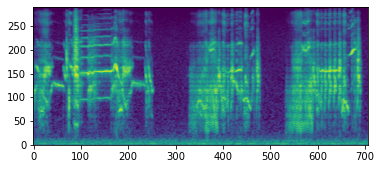

In [13]:
plt.imshow(spec_list[0], origin='lower')

In [14]:
subj_list = spec_df.name.values.tolist()

In [15]:
n_slices = (8, 1)

# This notebook is on only horizontal slices (spectral slices)

## Define model

In [37]:
clear_session()

In [16]:
def self_VGG(weights=None, trainable=True):
    if weights!='imagenet' and weights is not None:
        raise ValueError('Non-imagenet weights not supported yet.')
        
    img_model = tf.keras.applications.VGG19(include_top=False, weights=weights, 
                                        input_shape=(224, 224, 3), pooling='avg')
    
    if not trainable:
        img_model.trainable=False
        
    return img_model

## parse inputs and outputs

In [17]:
divided_w = spec_w//3
divided_h = spec_h//8

In [18]:
input_list = []
output_list = []

for spec in spec_list:
    for i in range(3):
        slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)], 
                                              n_slices=n_slices, slice_shape=(divided_h, 224))
        input_list.append(slice_list)
        output_list.append(index_list)

In [19]:
input_data = np.array(input_list)

In [20]:
input_data = np.transpose(input_data, (1, 0, 2, 3, 4))

In [21]:
input_data = list(input_data)

In [22]:
output_data = np.array(output_list)

In [23]:
output_data.shape

(21000, 8)

In [24]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_list, test_size = 0.1, 
                                                                      random_state=20)

In [25]:
n_train, _, h, w, _ = np.array(input_train).shape

In [26]:
print(n_train, h, w)

18900 36 224


In [38]:
model=self_VGG()

## connect dense layers and input/output

In [39]:
model_inputs = []
for i in range(np.product(n_slices)):
    model_inputs.append(Input(shape=(h, w, 3)))

In [40]:
encodings = []
for i in range(np.product(n_slices)):
    resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs[i])
    encodings.append(model(resized))
concated = layers.Concatenate(axis=1)(encodings)
dense = layers.Dense(4096)(concated)
model_output = layers.Dense(np.product(n_slices))(dense) # this needs to be changed for both temporal and spectral slices
cfn = Model(model_inputs, model_output)

In [41]:
cfn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36, 224, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 36, 224, 3)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 36, 224, 3)] 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 36, 224, 3)] 0                                            
_______________________________________________________________________________________

In [42]:
cfn.compile(loss='mse', optimizer = Adam(0.0001)) # need to figure out how to implement FY loss

## train the model

In [43]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now()))
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model trained on spectral slicing of Starling songs in star scale, 8 slices')

In [44]:
patience = 20
batch_size = 16
epochs = 1000

In [ ]:
model_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
            ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)]

cfn.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 18900 samples, validate on 2100 samples
Epoch 1/1000
18900/18900 [==============================] - ETA: 0s - loss: 1.9387WARNING:tensorflow:From /home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
18900/18900 [==============================] - 1163s 62ms/sample - loss: 1.9387 - val_loss: 0.2813
Epoch 2/1000
18900/18900 [==============================] - 1165s 62ms/sample - loss: 0.1370 - val_loss: 0.0850
Epoch 3/1000
18900/18900 [==============================] - 1161s 61ms/sample - loss: 0.0764 - val_loss: 0.1324
Epoch 4/1000
18900/18900 [==============================] - 1166s 62ms/sample - loss: 0.0559 - val_loss: 0.0504
Epoch 5/1000
18900/18900 [===========================

In [ ]:
pickle.dump([input_data, output_data], open(os.path.join(run_folder, 'train_data.p'), 'wb'))

In [46]:
cfn.load_weights(model_file)

In [47]:
input_test = np.array(input_test)

In [40]:
print(input_test.shape)

(2100, 4, 55, 224, 3)


In [48]:
input_test = list(input_test.transpose((1,0,2,3,4)))

In [49]:
prediction_test = cfn.predict(input_test)

In [50]:
prediction_test[0]

array([2.0058460e+00, 4.0046234e+00, 2.9978430e+00, 5.9969621e+00,
       1.0027782e+00, 4.9934673e+00, 1.5761554e-03, 7.0002360e+00],
      dtype=float32)

## prediction error (rmse)

In [51]:
print(np.sqrt(np.mean(np.square(prediction_test-output_test))))

0.011951869013919958


In [55]:
del cfn

In [52]:
prediction_test_int = np.round(prediction_test)

In [53]:
print(prediction_test_int[1])

[5. 3. 7. 4. 6. 1. 2. 0.]


In [54]:
print(np.mean(prediction_test_int==output_test))

0.9999404761904762


# fine tune on subject classification

## first use the original architecture (divide each spectrogram into smaller pieces and extract features from that) and untrainable on pretrained weights

### make inputs and outputs

In [14]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8108079, -0.8187467, -0.73811615, -0.7100..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.6495938, -0.6665916, -0.8675173, -0.65407..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.41882968, -0.3836928, -0.4552099, -0.3786..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.6679513, -0.7912686, -0.68081516, -0.5816..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.7382618, -0.682344, -0.6230346, -0.532324..."


In [48]:
subj_list = spec_df.name.values.tolist()

In [51]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
output_data = enc.fit_transform(np.array(subj_list).reshape((len(subj_list), 1))).toarray()

In [52]:
import itertools
output_data = np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in output_data)))

In [53]:
np.unique(outputs, return_counts=True, axis=0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500,


In [19]:
input_list = []
output_list = []

for spec in spec_list:
    spec_h, spec_w = spec.shape
    divided_w = spec_w//3
    for i in range(3):
        slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)], 
                                              n_slices=n_slices, 
                                              slice_shape=(spec_h//n_slices[0], divided_w//n_slices[1]), 
                                              permute=False)
        input_list.append(slice_list)

In [20]:
n_samples, n_outputs=outputs.shape
h, w = input_list[0][0].shape[:2]
print(n_samples, n_outputs, h, w)

21000 14 57 235


In [21]:
input_train, input_test, output_train, output_test = train_test_split(input_list, outputs, test_size = 0.2, 
                                                                      random_state=20, stratify=outputs)

In [22]:
input_train = list(np.array(input_train).transpose((1, 0, 2, 3, 4)))

In [23]:
input_train[0].shape

(16800, 57, 235, 3)

In [24]:
input_test = list(np.array(input_test).transpose((1, 0, 2, 3, 4)))
output_train = np.array(output_train)
output_test = np.array(output_test)

### make model

In [ ]:
clear_session()

In [25]:
model=alexnet((h, w, 3), trainable=False)
model_inputs = []
for i in range(np.product(n_slices)):
    model_inputs.append(Input(shape=(h, w, 3)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 59, 59, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1

In [26]:
encodings = []
for i in range(np.product(n_slices)):
    encodings.append(model(model_inputs[i]))
concated = layers.Concatenate(axis=1)(encodings)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(concated)
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, output)

In [27]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/self_supervision/2021_05_18_20_00_28/weights-improvement.h5'),
                       by_name=True)

In [28]:
classifier.compile(loss='categorical_crossentropy', optimizer = Adam(0.000001), metrics=['accuracy'])

In [29]:
results_folder = os.path.abspath('/mnt/cube/kai/results/self_supervision')
run_folder = extend_folder(results_folder, '2021_05_18_20_00_28', 'subj_classification', 'segmented')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on spectral slicing of Starling songs, fine tuned on subject classification (Starling)')

In [30]:
patience = 20
batch_size = 32
epochs = 1000

In [31]:
model_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=model_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_train, y = output_train, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 15120 samples, validate on 1680 samples
Epoch 1/1000
15120/15120 [==============================] - ETA: 0s - loss: 2.6419 - accuracy: 0.0867WARNING:tensorflow:From /home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
15120/15120 [==============================] - 61s 4ms/sample - loss: 2.6419 - accuracy: 0.0867 - val_loss: 2.6018 - val_accuracy: 0.1411
Epoch 2/1000
15120/15120 [==============================] - 62s 4ms/sample - loss: 2.5988 - accuracy: 0.1262 - val_loss: 2.5627 - val_accuracy: 0.1720
Epoch 3/1000
15120/15120 [==============================] - 61s 4ms/sample - loss: 2.5600 - accuracy: 0.1487 - val_loss: 2.5243 - val_accuracy: 0.1869
Epoch 4/1000
15120/15120 [===

Epoch 105/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.9868 - accuracy: 0.6536 - val_loss: 0.9948 - val_accuracy: 0.6435
Epoch 106/1000
15120/15120 [==============================] - 47s 3ms/sample - loss: 0.9822 - accuracy: 0.6538 - val_loss: 0.9893 - val_accuracy: 0.6429
Epoch 107/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.9763 - accuracy: 0.6563 - val_loss: 0.9830 - val_accuracy: 0.6440
Epoch 108/1000
15120/15120 [==============================] - 47s 3ms/sample - loss: 0.9721 - accuracy: 0.6568 - val_loss: 0.9807 - val_accuracy: 0.6435
Epoch 109/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.9618 - accuracy: 0.6600 - val_loss: 0.9769 - val_accuracy: 0.6446
Epoch 110/1000
15120/15120 [==============================] - 47s 3ms/sample - loss: 0.9605 - accuracy: 0.6610 - val_loss: 0.9722 - val_accuracy: 0.6446
Epoch 111/1000
15120/15120 [==============================] - 47s 3ms/sample - los

15120/15120 [==============================] - 49s 3ms/sample - loss: 0.6369 - accuracy: 0.7610 - val_loss: 0.7375 - val_accuracy: 0.7048
Epoch 212/1000
15120/15120 [==============================] - 49s 3ms/sample - loss: 0.6319 - accuracy: 0.7653 - val_loss: 0.7370 - val_accuracy: 0.7000
Epoch 213/1000
15120/15120 [==============================] - 49s 3ms/sample - loss: 0.6305 - accuracy: 0.7651 - val_loss: 0.7356 - val_accuracy: 0.7042
Epoch 214/1000
15120/15120 [==============================] - 49s 3ms/sample - loss: 0.6250 - accuracy: 0.7672 - val_loss: 0.7356 - val_accuracy: 0.7030
Epoch 215/1000
15120/15120 [==============================] - 48s 3ms/sample - loss: 0.6257 - accuracy: 0.7655 - val_loss: 0.7359 - val_accuracy: 0.6982
Epoch 216/1000
15120/15120 [==============================] - 49s 3ms/sample - loss: 0.6230 - accuracy: 0.7663 - val_loss: 0.7324 - val_accuracy: 0.7012
Epoch 217/1000
15120/15120 [==============================] - 48s 3ms/sample - loss: 0.6248 - acc

15120/15120 [==============================] - 54s 4ms/sample - loss: 0.4657 - accuracy: 0.8210 - val_loss: 0.6500 - val_accuracy: 0.7274
Epoch 318/1000
15120/15120 [==============================] - 54s 4ms/sample - loss: 0.4643 - accuracy: 0.8220 - val_loss: 0.6494 - val_accuracy: 0.7238
Epoch 319/1000
15120/15120 [==============================] - 55s 4ms/sample - loss: 0.4656 - accuracy: 0.8194 - val_loss: 0.6513 - val_accuracy: 0.7274
Epoch 320/1000
15120/15120 [==============================] - 54s 4ms/sample - loss: 0.4628 - accuracy: 0.8193 - val_loss: 0.6510 - val_accuracy: 0.7304
Epoch 321/1000
15120/15120 [==============================] - 54s 4ms/sample - loss: 0.4627 - accuracy: 0.8212 - val_loss: 0.6505 - val_accuracy: 0.7321
Epoch 322/1000
15120/15120 [==============================] - 54s 4ms/sample - loss: 0.4605 - accuracy: 0.8213 - val_loss: 0.6506 - val_accuracy: 0.7268
Epoch 323/1000
15120/15120 [==============================] - 54s 4ms/sample - loss: 0.4585 - acc

In [32]:
classifier.load_weights(model_file)
prediction_test = classifier.predict(input_test)

In [33]:
prediction_logits = np.argmax(prediction_test, axis=1)

In [34]:
output_logits = np.argmax(output_test, axis=1)

### subj classification accuracy

In [35]:
np.mean(prediction_logits==output_logits)

0.7571428571428571

## now spectrograms as a whole

In [56]:
subj_list = spec_df.name.values.tolist()

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
output_data = enc.fit_transform(np.array(subj_list).reshape((len(subj_list), 1))).toarray()

In [16]:
import itertools
output_data = np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in output_data)))

In [17]:
np.unique(output_data, return_counts=True, axis=0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500,


In [18]:
input_list = []
for spec in spec_list:
    spec_h, spec_w = spec.shape
    divided_w = spec_w//3
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        input_list.append(np.stack([s, s, s], axis = 2))

In [19]:
input_list = np.array(input_list)

In [20]:
input_list.shape

(21000, 291, 235, 3)

In [21]:
n_samples, n_outputs=output_data.shape
h, w = input_list[0].shape[:2]
print(n_samples, n_outputs, h, w)

21000 14 291 235


In [22]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_data, test_size = 0.2, 
                                                                      random_state=20, stratify=output_data)

In [23]:
input_train = np.array(input_train)
input_test = np.array(input_test)
output_train = np.array(output_train)
output_test = np.array(output_test)

### make model

In [24]:
clear_session()

In [25]:
model=self_VGG()

In [26]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, model_output)

In [27]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 291, 235, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [28]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_19_16_56_50/weights-improvement.h5'),
                       by_name=True)

In [29]:
classifier.compile(loss='categorical_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [30]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2021_07_19_16_56_50', 'subj_classification', 'unsegmented_trainable')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on whole Starling songs in star scale without slicing, \
               fine tuned on subject classification (Starling), pretrained weights are trainable')

In [31]:
patience = 20
batch_size = 32
epochs = 1000

In [ ]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_train, y = output_train, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 15120 samples, validate on 1680 samples
Epoch 1/1000
 3680/15120 [======>.......................] - ETA: 1:28 - loss: 2.6388 - accuracy: 0.0780

In [33]:
classifier.load_weights(weights_file)
prediction_test = classifier.predict(input_test)

In [34]:
prediction_logits = np.argmax(prediction_test, axis=1)

In [35]:
output_logits = np.argmax(output_test, axis=1)

### subj classification accuracy

In [36]:
np.mean(prediction_logits==output_logits)

0.8095238095238095